# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

## Read the CSV and Perform Basic Data Cleaning

In [4]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


## Split the Data into Training and Testing

In [5]:
# Create our features

train = df.iloc[:60000]
test = df.iloc[60001:]

X = df.copy()
X.drop(columns=['loan_status','home_ownership', 'verification_status', 'issue_d','pymnt_plan','application_type','initial_list_status','next_pymnt_d','hardship_flag','debt_settlement_flag'], axis =1, inplace=True)

# ^ slice data into train and test data. 
# We have to drop the extra columns of because they do not have float-value convertible data and  also NOT binary. 

# Create our target
y = df['loan_status']


In [6]:
X.describe()

# in viewing our X variable, we can ensure that we have float() items in the dataframe, we do.

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.052138,2.219423,95.057627,30.626217,0.125972,0.0,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.390633,1.897432,8.326426,33.631463,0.336732,0.0,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,20.000000,0.000000,0.000000,0.0,3.600000e+03,2.350000e+02,100.000000,1.270000e+02
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.000000,93.000000,0.000000,0.000000,0.0,6.697700e+04,2.650300e+04,11600.000000,2.288000e+04
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,2.000000,100.000000,20.000000,0.000000,0.0,1.467100e+05,4.535700e+04,22100.000000,4.200000e+04
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,3.000000,100.000000,50.000000,0.000000,0.0,3.036400e+05,7.657000e+04,39300.000000,7.249900e+04
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,18.000000,19.000000,100.000000,100.000000,4.000000,0.0,3.292782e+06,1.295455e+06,509400.000000,1.426964e+06


In [7]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [8]:
# Split the X and y into X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 78)

X_train.shape

(51612, 76)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [9]:
# Create the StandardScaler instance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [10]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [11]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

X_train.shape

(51612, 76)

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [12]:
# Resample the training data with the BalancedRandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model = rf_model.fit(X_train_scaled, y_train)
predictions = rf_model.predict(X_test_scaled)


In [13]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred = rf_model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5

In [14]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[    0,    92],
       [    0, 17113]], dtype=int64)

In [15]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.00      0.00      1.00      0.00      0.00      0.00        92
   low_risk       0.99      1.00      0.00      1.00      0.00      0.00     17113

avg / total       0.99      0.99      0.01      0.99      0.00      0.00     17205



In [16]:
# List the features sorted in descending order by feature importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)


[(0.08385868990767711, 'last_pymnt_amnt'),
 (0.07107904949370161, 'total_pymnt_inv'),
 (0.06920395011837514, 'total_rec_prncp'),
 (0.06707512892034846, 'total_rec_int'),
 (0.06644144702098016, 'total_pymnt'),
 (0.021139287678500294, 'mo_sin_old_rev_tl_op'),
 (0.019310000356490716, 'dti'),
 (0.016946083275508096, 'max_bal_bc'),
 (0.01656201232697395, 'mo_sin_old_il_acct'),
 (0.016452223368964392, 'bc_open_to_buy'),
 (0.016251366540047267, 'total_rec_late_fee'),
 (0.0162239848777472, 'revol_bal'),
 (0.01584413004328504, 'out_prncp'),
 (0.015767236125152847, 'out_prncp_inv'),
 (0.01567538673730582, 'bc_util'),
 (0.015328257154585303, 'tot_hi_cred_lim'),
 (0.01525575054078087, 'total_bal_il'),
 (0.015144792046333842, 'total_bal_ex_mort'),
 (0.015051792479662629, 'tot_cur_bal'),
 (0.014568535133216442, 'avg_cur_bal'),
 (0.014449197264835853, 'total_bc_limit'),
 (0.014403849555137897, 'installment'),
 (0.013783811019612832, 'total_rev_hi_lim'),
 (0.013588119701201832, 'annual_inc'),
 (0.0133

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

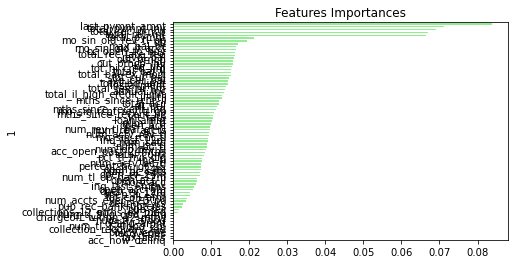

In [17]:
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)


# Not so helpful.  We have too many dependent variables. 
# But might be useful to use this chart to compare with the printed list in the above cell 

### Easy Ensemble Classifier

In [21]:
# Train the Classifier
# This is a value call. Easy Ensemble Classifier - is a "balanced" and "boosting" classifier algorithm. 
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    classifier = GradientBoostingClassifier(n_estimators=20,
                                            learning_rate=learning_rate,
                                            max_features=5,
                                            max_depth=3,
                                            random_state=0)

    # Fit the model
    classifier.fit(X_train_scaled, y_train.ravel())
    print("Learning rate: ", learning_rate)

    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        classifier.score(
            X_train_scaled,
            y_train.ravel())))
    print("Accuracy score (validation): {0:.3f}".format(
        classifier.score(
            X_test_scaled,
            y_test.ravel())))
    print()

    
predictions = classifier.predict(X_test_scaled)
pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()}).head(20)

Learning rate:  0.05
Accuracy score (training): 0.995
Accuracy score (validation): 0.994

Learning rate:  0.1
Accuracy score (training): 0.995
Accuracy score (validation): 0.994

Learning rate:  0.25
Accuracy score (training): 0.995
Accuracy score (validation): 0.993

Learning rate:  0.5
Accuracy score (training): 0.995
Accuracy score (validation): 0.993

Learning rate:  0.75
Accuracy score (training): 0.995
Accuracy score (validation): 0.993

Learning rate:  1
Accuracy score (training): 0.995
Accuracy score (validation): 0.994



,Prediction,Actual
0,low_risk,low_risk
1,low_risk,low_risk
2,low_risk,low_risk
3,low_risk,low_risk
4,low_risk,low_risk
5,low_risk,low_risk
6,low_risk,low_risk
7,low_risk,low_risk
8,low_risk,low_risk
9,low_risk,low_risk


In [24]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
acc_score = balanced_accuracy_score(y_test, predictions)
print(f"Accuracy Score : {acc_score}")


Accuracy Score : 0.4997369036482694


In [27]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)

# Displaying results
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,0,101
Actual 1,9,17095


In [32]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

print("Classification Report")
print(classification_report_imbalanced(y_test, y_pred))


              precision    recall  f1-score   support

   high_risk       0.00      0.00      0.00       101
    low_risk       0.99      1.00      1.00     17104

    accuracy                           0.99     17205
   macro avg       0.50      0.50      0.50     17205
weighted avg       0.99      0.99      0.99     17205

Classification Report
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.00      0.00      1.00      0.00      0.00      0.00       101
   low_risk       0.99      1.00      0.00      1.00      0.00      0.00     17104

avg / total       0.99      0.99      0.01      0.99      0.00      0.00     17205



### Final Questions

1. Which model had the best balanced accuracy score?

***The Random Forest Classifier had the better score, but only by a slight margin,  50% vs 49%***

2. Which model had the best recall score?

***Both models had terrible recall scores.  0% for 'high-risk' segment, and 100% for 'low-risk' segments.  Not exactly a profound model, because it weights the data in favor of low-Risk loans, which already do not need any additional classification or warning.  It's the high-risk category that needs help, and neither of these models does any favors for high-risk loans.  

3. Which model had the best geometric mean score?

***Neither, this model does not work.  Both scored 0*** 

4. What are the top three features?

'last_pymnt_amnt'),
 'total_pymnt_inv'),
 'total_rec_prncp'),
 'total_rec_int'),
 
 
***which makes a lot of sense.  Payment history is a large indicator of future credit-worthiness the inverse, 'credit-riskiness'. 


Great

### Sources 

1. https://towardsdatascience.com/understanding-random-forest-58381e0602d2
    